<a href="https://colab.research.google.com/github/CarlosSotero/Reconhecimento-Facial/blob/main/Pr%C3%A1tica_de_Reconhecimento_Facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

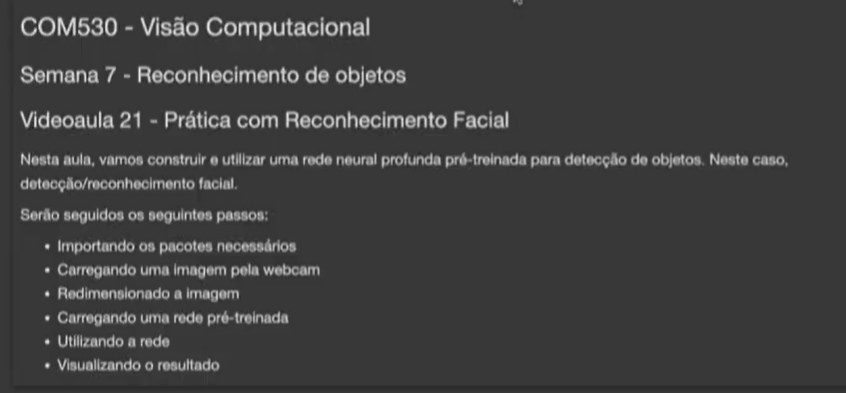

## **Importando os pacotes do Python necessários**

In [4]:
# Biblioteca imutils — facilita operações comuns de visão computacional,
# como redimensionamento e manipulação de imagens.
import imutils

# NumPy — essencial para trabalhar com matrizes e tensores de imagem.
import numpy as np

# OpenCV — principal biblioteca de visão computacional (leitura, escrita, filtros e transformações).
import cv2

# Função especial do Google Colab para exibir imagens do OpenCV,
# pois cv2.imshow não funciona em ambiente web.
from google.colab.patches import cv2_imshow

# Para exibir JavaScript dentro do notebook (por exemplo, captura de webcam).
from IPython.display import display, Javascript

# Permite executar código JavaScript e retornar valores para o Python.
from google.colab.output import eval_js

# Para decodificar strings base64 (útil ao capturar imagens pela webcam no Colab).
from base64 import b64decode

##**Carregando uma imagem pela webcam**

**Iniciando a Webcam**

In [5]:
def take_photo(filename='photo.jpg', quality=0.8):
    """
    Captura uma foto da webcam no Google Colab e salva em disco.

    Parâmetros:
        filename (str): nome do arquivo de saída (ex.: 'photo.jpg').
        quality (float): qualidade JPEG (0.0 a 1.0) usada ao exportar no browser.

    Retorna:
        str: caminho do arquivo salvo (igual a 'filename').
    """
    # Bloco JavaScript que será injetado e executado no notebook.
    # Ele cria elementos na página (um <video> e um botão), pede acesso à webcam,
    # mostra o vídeo ao vivo, espera o clique em "Capturar", captura o frame em um
    # <canvas> e devolve um DataURL (base64) da imagem em JPEG.
    js = Javascript('''
    async function takePhoto(quality) {
      // Cria um contêiner e um botão "Capturar"
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capturar';
      div.appendChild(capture);

      // Cria o elemento de vídeo e solicita acesso à webcam
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      // Insere os elementos no DOM e inicia o vídeo
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Ajusta a altura do iframe do Colab para caber vídeo/botão
      google.colab.output.setIframeHeight(
        document.documentElement.scrollHeight, true
      );

      // Aguarda o clique no botão "Capturar"
      await new Promise((resolve) => capture.onclick = resolve);

      // Cria um canvas do mesmo tamanho do vídeo e desenha o frame atual
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);

      // Encerra a captura da webcam e remove os elementos da página
      stream.getVideoTracks()[0].stop();
      div.remove();

      // Retorna a imagem como DataURL (JPEG) com a qualidade indicada
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')

    # Exibe/instala o JS acima no notebook
    display(js)

    # Chama a função JS e recebe de volta um DataURL (ex.: "data:image/jpeg;base64,...")
    data = eval_js(f'takePhoto({quality})')

    # Converte a parte base64 do DataURL em bytes
    img_bytes = b64decode(data.split(',')[1])

    # Salva a imagem no caminho/arquivo indicado
    with open(filename, 'wb') as f:
        f.write(img_bytes)

    # Retorna o nome do arquivo salvo
    return filename

In [6]:
# Tirando a foto utilizando a webcam
image_file = take_photo()

<IPython.core.display.Javascript object>

## **Redimensionando a imagem**

400 300


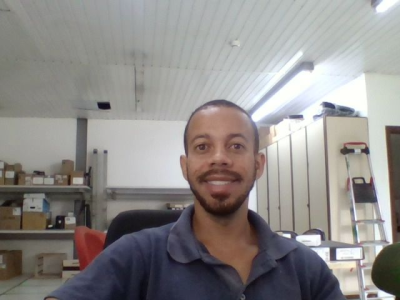

In [7]:
# Lê a imagem salva no disco usando OpenCV.
# imread() retorna uma imagem no formato BGR.
image = cv2.imread(image_file)

# Redimensiona a imagem para largura de 400 pixels,
# mantendo a proporção automaticamente (imutils facilita isso).
image = imutils.resize(image, width=400)

# Obtém altura (h) e largura (w) da imagem.
# image.shape -> (altura, largura, canais)
(h, w) = image.shape[:2]

# Exibe a largura e altura
print(w, h)

# Como cv2.imshow não funciona no Google Colab,
# usamos cv2_imshow para exibir a imagem.
cv2_imshow(image)

## **Carregando uma rede pré-treinada**

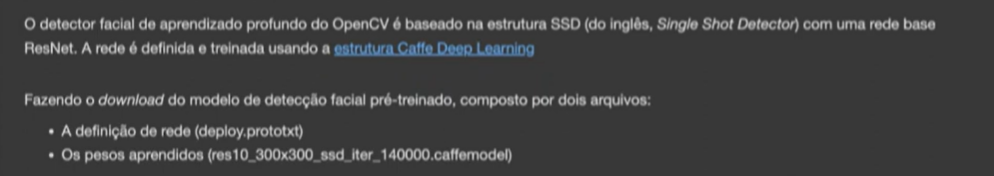

In [8]:
# Baixa o arquivo de configuração do modelo (prototxt) do detector de faces da OpenCV (Caffe).
# -N = ativa timestamping para não rebaixar se o arquivo local já estiver atualizado.
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

# Baixa os pesos do modelo (CaffeModel) - arquitetura ResNet-10 + SSD, treinado para 300x300.
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2026-02-10 12:21:53--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2026-02-10 12:21:53 (18.7 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2026-02-10 12:21:53--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [9]:
# Carregando o modelo pré-treinado

print('[INFO] Carregando o Modelo...')

# Caminho para o arquivo .prototxt (define a arquitetura da rede).
# Esse arquivo descreve as camadas do SSD baseado em ResNet-10.
prototxt = 'deploy.prototxt'

# Caminho para o arquivo .caffemodel (contém os pesos treinados).
# É o modelo pré-treinado de detecção de rostos da OpenCV.
model = 'res10_300x300_ssd_iter_140000.caffemodel'

# Carrega o modelo da rede neural usando OpenCV DNN (Deep Neural Network).
# readNetFromCaffe() precisa dos 2 arquivos:
#   1) .prototxt   → estrutura
#   2) .caffemodel → pesos
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] Carregando o Modelo...


## **Utilizando a rede**

In [10]:
# Usando a função dnn.blobFromImage para construir um blob de entrada redimensionando a imagem para 300 x 300 pixels e,
# posteriormente normalizando seus valores

image = imutils.resize(image, width=400)

# Cria um "blob" a partir da imagem — estrutura usada como entrada do modelo DNN do OpenCV.
# O blob padroniza a imagem (tamanho, escala, normalização) antes do forward pass.
blob = cv2.dnn.blobFromImage(
    cv2.resize(image, (300, 300)),  # Redimensiona a imagem para 300x300 (resolução esperada pelo SSD)
    1.0,                            # Fator de escala (multiplicador). Aqui = 1.0, então não altera a intensidade dos pixels.
    (300, 300),                     # Tamanho da imagem de entrada da rede (width, height)
    (104.0, 177.0, 123.0)           # Valores de média a serem subtraídos por canal (BGR) — normalização usada no treinamento do modelo.
)

In [11]:
print('[INFO] Computando as detecções de objetos...')
# Envia o blob como entrada para a rede neural do OpenCV.
# Aqui você coloca a imagem pré-processada (300x300, normalizada) dentro do modelo.
net.setInput(blob)

# Executa o forward pass na rede.
# A rede SSD (Single Shot Detector) retorna todas as detecções encontradas na imagem:
# - coordinates (x1, y1, x2, y2)
# - probabilidades (confidence)
# - índice da classe (no caso, sempre "face")
detections = net.forward()

[INFO] Computando as detecções de objetos...


**Procurando por detecções e desenhando caixas ao redor dos rostos detectados**

In [12]:
# Loop por todas as detecções retornadas pela rede
for i in range(0, detections.shape[2]):
    # Extrai a confiança (probabilidade) associada à detecção i
    # No tensor 'detections', o índice [0, 0, i, 2] corresponde ao score (confidence)
    confidence = detections[0, 0, i, 2]

    # Filtra detecções fracas garantindo que a confiança seja maior que o limiar mínimo
    if confidence > 0.5:
        # Calcula as coordenadas (x1, y1, x2, y2) da caixa delimitadora (bounding box)
        # O modelo retorna coordenadas normalizadas (0..1), então multiplicamos por (w, h, w, h)
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")

        # Monta o texto com a probabilidade em porcentagem (2 casas decimais)
        text = "{:.2f}%".format(confidence * 100)

        # Define a coordenada Y do texto.
        # Se tiver espaço acima da caixa, escreve 10 px acima; caso contrário, 10 px abaixo.
        y = startY - 10 if startY - 10 > 10 else startY + 10

        # Desenha a bounding box da face
        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

        # Escreve o texto de confiança próximo da caixa
        cv2.putText(
            image, text, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2
        )

## **Visualizando o resultado**

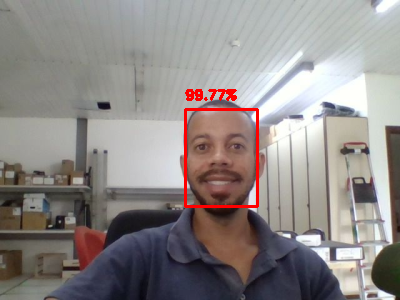

In [13]:
cv2_imshow(image)